#### This dataset contains the hourly and daily count of rental bikes between the years 2011 and 2012 in the Capital bike share system with the corresponding weather and seasonal information.

   ` Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv For our project, we shall be using the hourly dataset (hour.csv) only`

  Data Dictionary

  1. instant: record index
  2. dteday : date
  3. season : season (1:spring, 2:summer, 3:fall, 4:winter)
  4. yr : year (0: 2011, 1:2012)
  5. mnth : month ( 1 to 12)
  6. hr : hour (0 to 23)
  7. holiday : weather day is holiday or not (extracted from [Web Link])
  8. weekday : day of the week
  9. workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
  10. weathersit :
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  11. temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
  12. atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
  13. hum: Normalized humidity. The values are divided to 100 (max)
  14. windspeed: Normalized wind speed. The values are divided to 67 (max)
  15. casual: count of casual users
  16. registered: count of registered users
  17. cnt: count of total rental bikes including both casual and registered


  `For further information visit the link:` https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

##### Data Preparation

In [290]:
#importing the required libraries
import pandas as pd
import numpy as np
import io
import requests
import zipfile
from datetime import datetime, time
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.ensemble import RandomForestRegressor


import joblib

In [98]:
# dowloading the zipped dataset from the UCI repository.
downloaded_zipped = requests.get("https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip").content

In [99]:
# unzip the zipped folder and extract & read the hour.csv into a dataframe
with zipfile.ZipFile(io.BytesIO(downloaded_zipped)) as unzp:
  ori_df = pd.read_csv(unzp.open('hour.csv'))

In [100]:
ori_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [101]:
ori_df.shape

(17379, 17)

In [102]:
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [103]:
# ensuring index is a DateTimeIndex of dates
ori_df['dteday'] = pd.to_datetime(ori_df['dteday'])
ori_df.set_index('dteday', inplace=True)

In [104]:
# rebuilding the new date & timestamp index row‐by‐row
ori_df.index = ori_df.apply(
    lambda row: datetime.combine(row.name.date(), time(hour=int(row['hr']))),
    axis=1
)

In [105]:
# drop 'instant' which has become a column now
ori_df = ori_df.drop(columns=['instant'])

In [106]:
# setting meaningful names for the colums
ori_df.rename(columns={'yr':'year','mnth':'month','weathersit':'weather_condition', 'atemp': 'feels_like_temp', 'hum':'humidity', 'casual' : 'casual_users', 'registered' : 'registered_users',  'cnt':'total_bike_rented_count'},inplace=True)

In [107]:
# verifying the changes
ori_df.head(10)

,season,year,month,hr,holiday,weekday,workingday,weather_condition,temp,feels_like_temp,humidity,windspeed,casual_users,registered_users,total_bike_rented_count
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
2011-01-01 05:00:00,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
2011-01-01 06:00:00,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
2011-01-01 07:00:00,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
2011-01-01 08:00:00,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
2011-01-01 09:00:00,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


##### Exploratory Data Analysis and Data Preprocessing

In [108]:
# checking the stats of the dataset
ori_df.describe()

,season,year,month,hr,holiday,weekday,workingday,weather_condition,temp,feels_like_temp,humidity,windspeed,casual_users,registered_users,total_bike_rented_count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


We can infer:

*   The maximum numbers of bike rented in an hour can be as big as 977
*   The average hourly rental count is 189
*   The minimum number of hourly bike rental count can be as low as 1








##### checking unique values in the whole dataset

In [109]:
ori_df.nunique()

,0
season,4
year,2
month,12
hr,24
holiday,2
weekday,7
workingday,2
weather_condition,4
temp,50
feels_like_temp,65


In [110]:
# checking for null values
ori_df.isnull().sum()

,0
season,0
year,0
month,0
hr,0
holiday,0
weekday,0
workingday,0
weather_condition,0
temp,0
feels_like_temp,0


##### So we see there is no null value in the dataset

In [111]:
# checking if duplicate rows exist in the dataset
ori_df.duplicated().sum()

np.int64(2)

In [112]:
# bring datetime index back as column to check exact duplicated rows
df_sau = ori_df.reset_index()
df_sau[df_sau.duplicated(keep=False)]

,index,season,year,month,hr,holiday,weekday,workingday,weather_condition,temp,feels_like_temp,humidity,windspeed,casual_users,registered_users,total_bike_rented_count


##### So we can sse that there is no duplicate rows in the dataset

In [113]:
# checking if there are any negative values in any of the attributes
ori_df.lt(0).sum()

,0
season,0
year,0
month,0
hr,0
holiday,0
weekday,0
workingday,0
weather_condition,0
temp,0
feels_like_temp,0


##### We can see that there is no negative values in any attributes/columns of the dataset. This is what-it-should-be/ideal  given the features in the dataset

#### Let us now identify the categorical and continuous features

In [18]:
# in view of this we set the categorical features
cat_cols = [
    'season', 'year', 'month', 'hr',
    'holiday', 'weekday', 'workingday', 'weather_condition'
]

##### We observe the continuous features in the dataset are: temp, feels_like_temp, humidity and windspeed

In [19]:
# so the numerical features
num_cols = [
    'temp', 'feels_like_temp', 'humidity', 'windspeed', 'casual_users', 'registered_users'
]

In [114]:
ori_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   season                   17379 non-null  int64  
 1   year                     17379 non-null  int64  
 2   month                    17379 non-null  int64  
 3   hr                       17379 non-null  int64  
 4   holiday                  17379 non-null  int64  
 5   weekday                  17379 non-null  int64  
 6   workingday               17379 non-null  int64  
 7   weather_condition        17379 non-null  int64  
 8   temp                     17379 non-null  float64
 9   feels_like_temp          17379 non-null  float64
 10  humidity                 17379 non-null  float64
 11  windspeed                17379 non-null  float64
 12  casual_users             17379 non-null  int64  
 13  registered_users         17379 non-null  

#### Analysis of the target variable

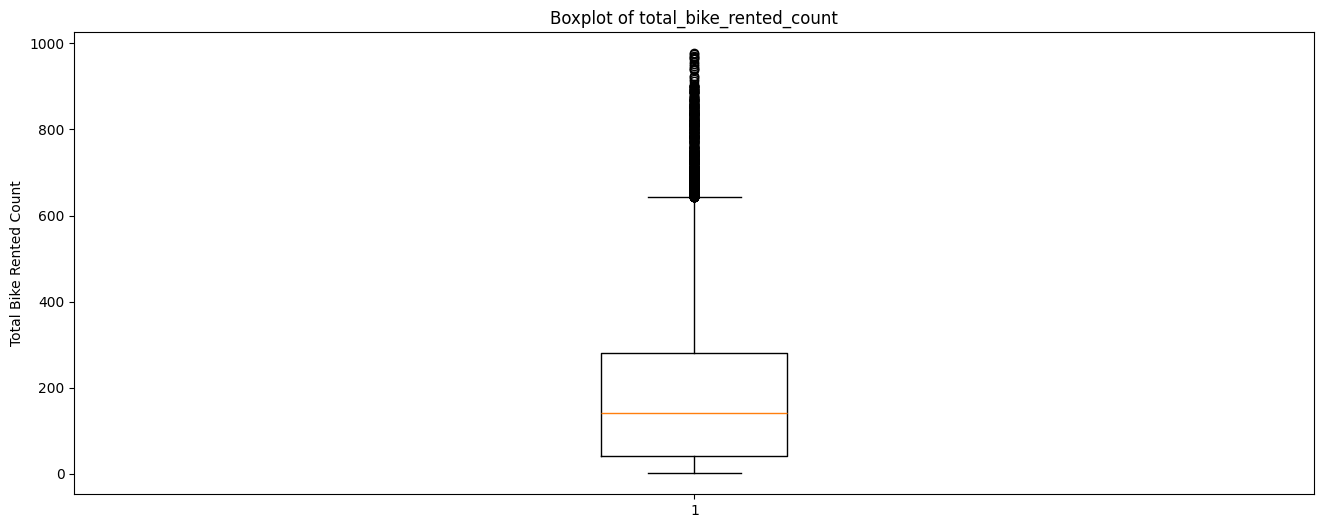

In [115]:
# Visualize the outliers in the target feature
plt.figure(figsize=(16, 6))
plt.boxplot(ori_df['total_bike_rented_count'], vert=True)
plt.title('Boxplot of total_bike_rented_count')
plt.ylabel('Total Bike Rented Count')
plt.show()

#### We observe outliers in the target feature

In [116]:
# check outlier removal strategy both with IQR Filter and  ±3σ Filter

counts = ori_df['total_bike_rented_count']

# 1) Compute thresholds
mu    = counts.mean()
sigma = counts.std()
lower_3s, upper_3s = mu - 3 * sigma, mu + 3 * sigma

Q1    = counts.quantile(0.25)
Q3    = counts.quantile(0.75)
IQR   = Q3 - Q1
lower_iqr, upper_iqr = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# 2) Build masks and dropped subsets
mask_3s   = counts.between(lower_3s, upper_3s)
mask_iqr  = counts.between(lower_iqr, upper_iqr)
dropped_3s  = counts[~mask_3s]
dropped_iqr = counts[~mask_iqr]

# 3) Summarize
summary = pd.DataFrame({
    'Method':         ['±3σ Filter', 'IQR Filter'],
    'Lower Bound':    [lower_3s, lower_iqr],
    'Upper Bound':    [upper_3s, upper_iqr],
    'Dropped Rows':   [len(dropped_3s), len(dropped_iqr)],
    'Min Dropped':    [dropped_3s.min(), dropped_iqr.min()],
    'Median Dropped': [dropped_3s.median(), dropped_iqr.median()],
    'Max Dropped':    [dropped_3s.max(), dropped_iqr.max()],
})
print(summary.to_string(index=False))

# 4) Show top‑5 extremes
print("\nTop 5 dropped by ±3σ:")
print(dropped_3s.sort_values(ascending=False).head(5).to_string())

print("\nTop 5 dropped by IQR:")
print(dropped_iqr.sort_values(ascending=False).head(5).to_string())


    Method  Lower Bound  Upper Bound  Dropped Rows  Min Dropped  Median Dropped  Max Dropped
±3σ Filter   -354.69971   733.625885           244          734           812.5          977
IQR Filter   -321.50000   642.500000           505          643           730.0          977

Top 5 dropped by ±3σ:
2012-09-12 18:00:00    977
2012-09-20 17:00:00    976
2012-09-11 17:00:00    970
2012-09-10 18:00:00    968
2012-09-25 17:00:00    967

Top 5 dropped by IQR:
2012-09-12 18:00:00    977
2012-09-20 17:00:00    976
2012-09-11 17:00:00    970
2012-09-10 18:00:00    968
2012-09-25 17:00:00    967


#### So we shall apply the IQR based outlier removal

In [117]:
df_iter = ori_df.copy()

while True:
    Q1 = df_iter['total_bike_rented_count'].quantile(0.25)
    Q3 = df_iter['total_bike_rented_count'].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

    # filter
    new_df = df_iter[
        df_iter['total_bike_rented_count'].between(lower, upper)
    ]
    if new_df.shape[0] == df_iter.shape[0]:
        break   # no more dropped rows → stable
    df_iter = new_df

cleaned = df_iter
print("Final rows:", cleaned.shape[0])

Final rows: 16678


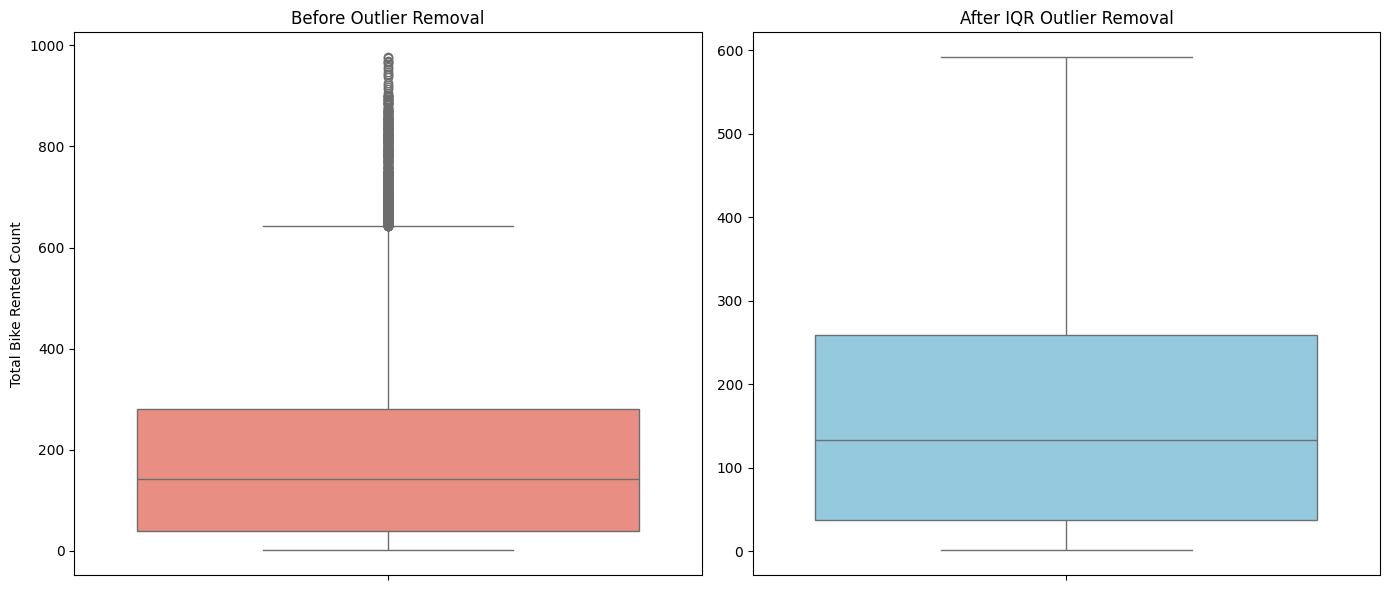

In [118]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

sns.boxplot(
    y=ori_df['total_bike_rented_count'],
    ax=axes[0],
    color='salmon'
)
axes[0].set_title('Before Outlier Removal')
axes[0].set_ylabel('Total Bike Rented Count')

sns.boxplot(
    y=cleaned['total_bike_rented_count'],
    ax=axes[1],
    color='skyblue'
)
axes[1].set_title('After IQR Outlier Removal')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

#### Analysis of the target variable with respect to the categorical attributes of the dataset

In [119]:
# let us visualize the target variable w.r.t the temporal features for each season
temporal_cols = ['hr', 'weekday']

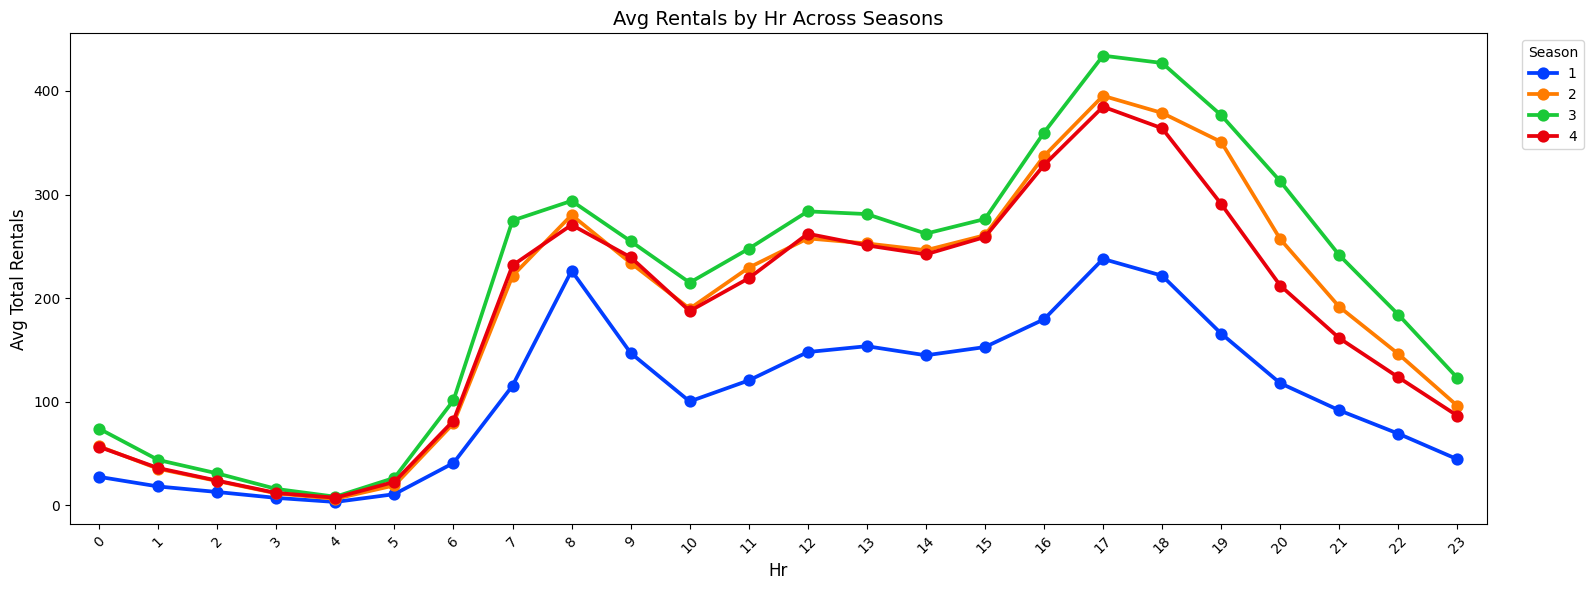

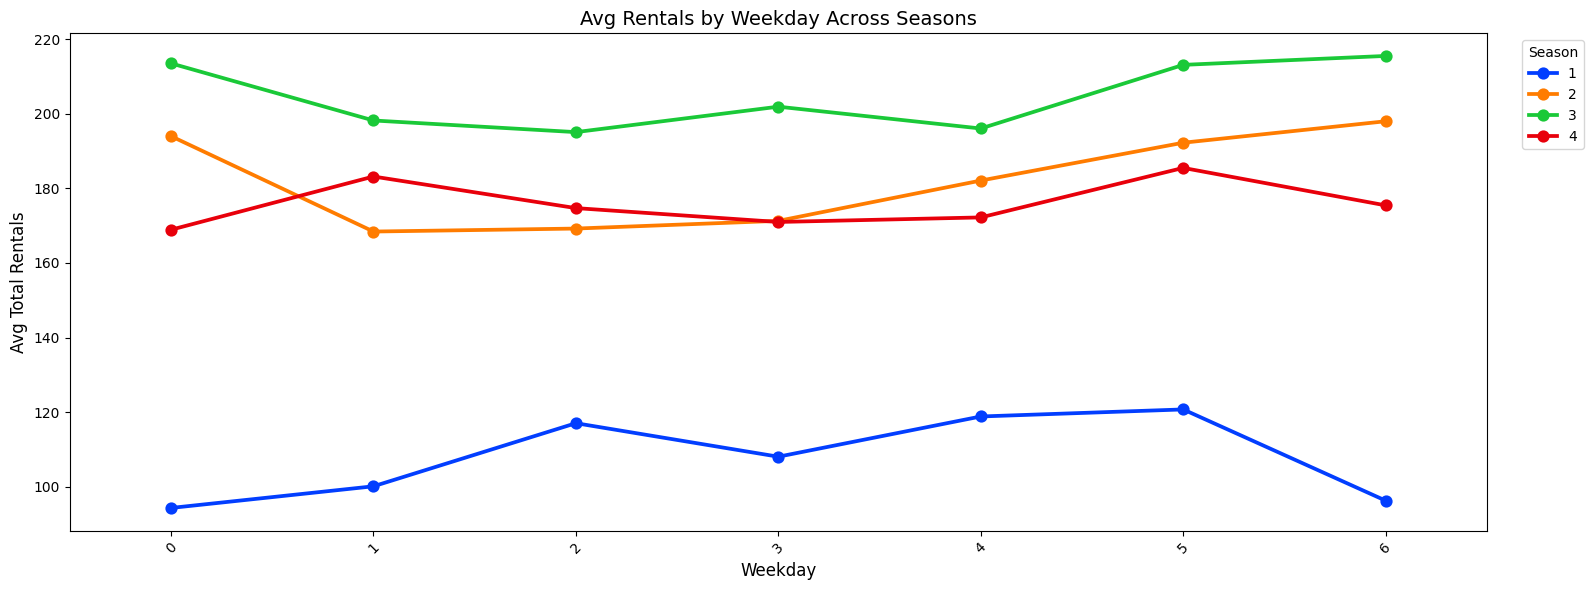

In [120]:
for col in temporal_cols:
    plt.figure(figsize=(16, 6))
    sns.pointplot(
        data=cleaned,
        x=col,
        y='total_bike_rented_count',
        hue='season',
        estimator='mean',
        errorbar=None,
        markers='o',
        linestyles='-',
        palette='bright'
    )
    plt.title(f'Avg Rentals by {col.capitalize()} Across Seasons', fontsize=14)
    plt.xlabel(col.capitalize(), fontsize=12)
    plt.ylabel('Avg Total Rentals', fontsize=12)
    plt.legend(title='Season', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print()
    print()

#### Now let us visualize the average count by month for each/hues with 'holiday', 'weekday', 'workingday', 'weather_condition'

/tmp/ipython-input-124-3486220859.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(month_order)  # enforce Jan→Dec


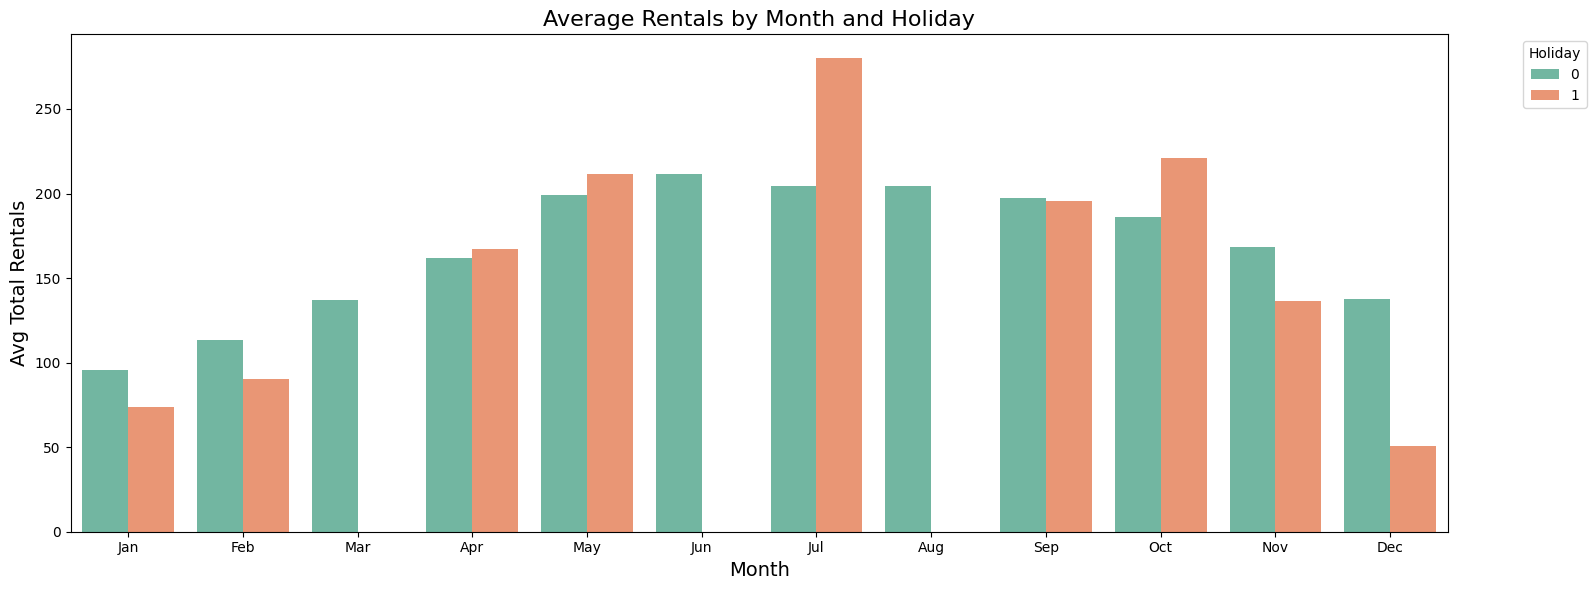

/tmp/ipython-input-124-3486220859.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(month_order)  # enforce Jan→Dec


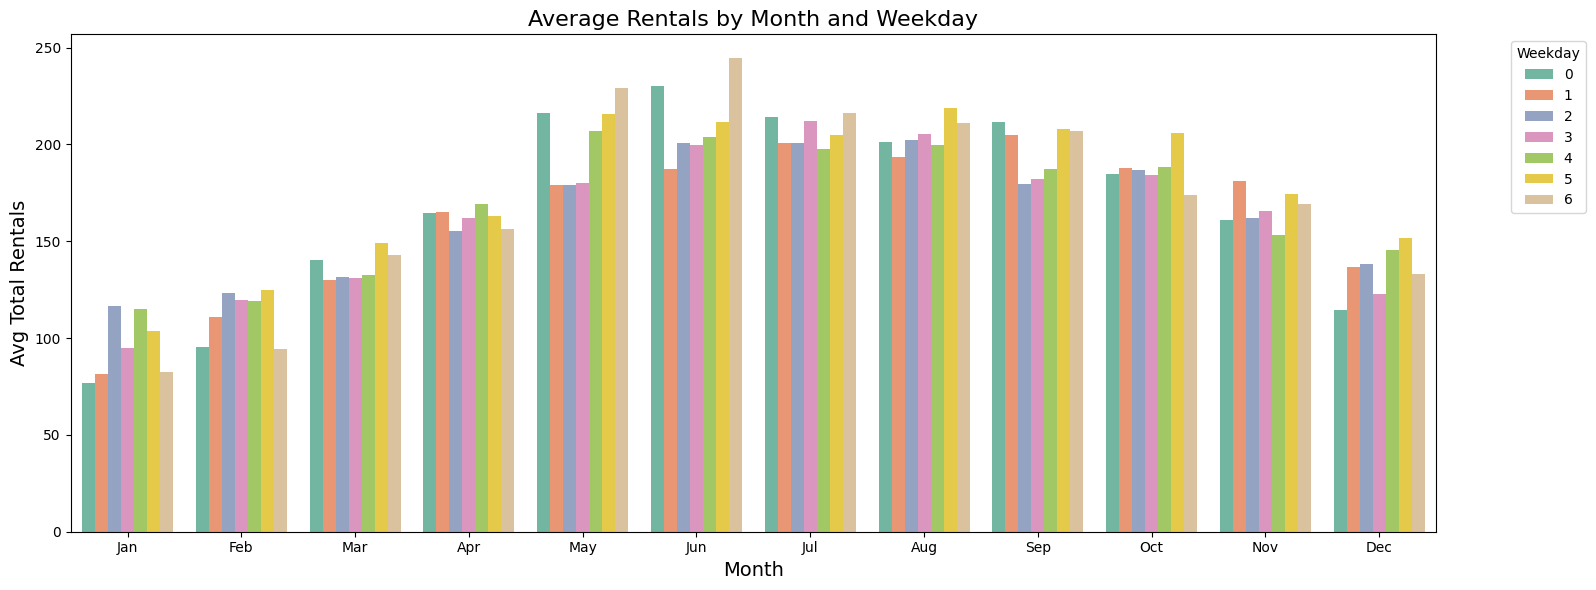

/tmp/ipython-input-124-3486220859.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(month_order)  # enforce Jan→Dec


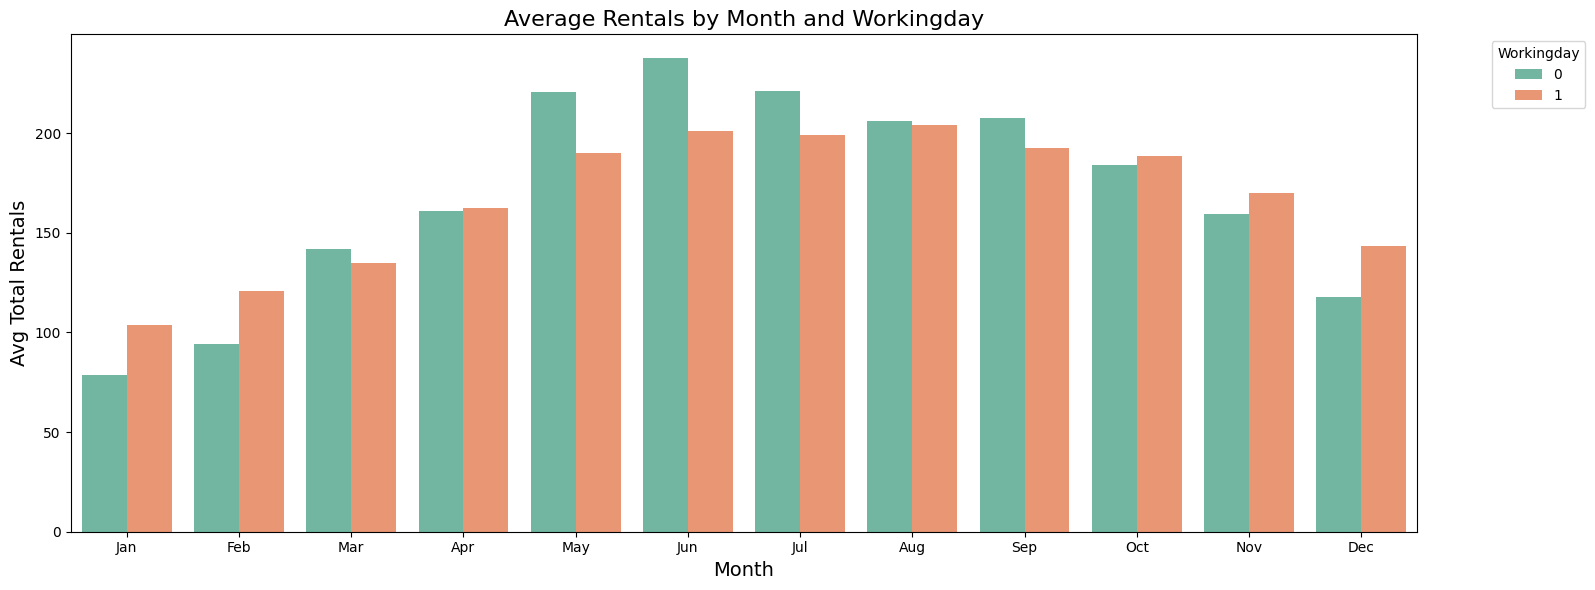

/tmp/ipython-input-124-3486220859.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(month_order)  # enforce Jan→Dec


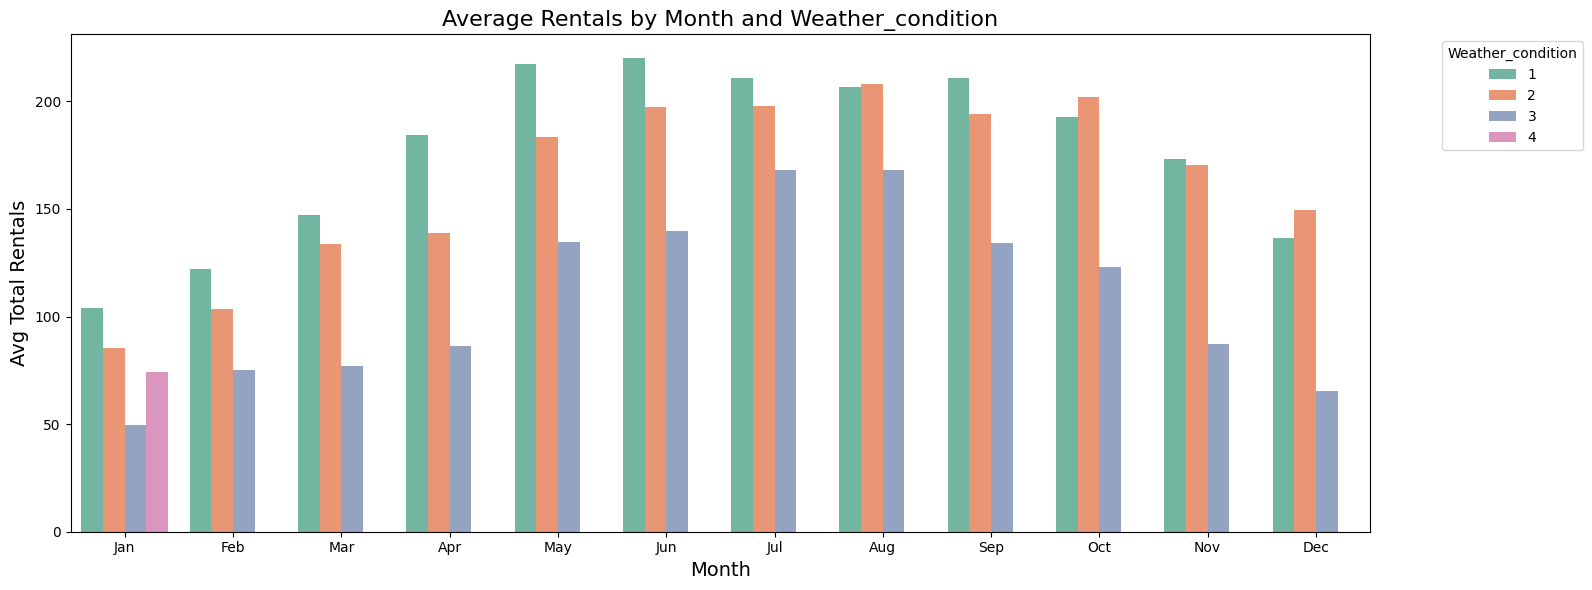

In [124]:
df = cleaned.copy()

# 1) Convert your existing month column to int
df['month'] = df['month'].astype(int)

# 2) (Optional) Create a month‐name column for prettier x‐ticks
df['month_name'] = df['month'].apply(lambda m: calendar.month_abbr[m])

# 3) Define the order of the months
month_order = list(calendar.month_abbr[1:])  # ['Jan','Feb', …, 'Dec']

# 4) Choose which categorical flags to hue by
hue_cols = ['holiday', 'weekday', 'workingday', 'weather_condition']

# 5) Loop and plot
for col in hue_cols:
    plt.figure(figsize=(16, 6))
    sns.barplot(
      data=df,
      x='month_name',
      y='total_bike_rented_count',
      hue=col,
      estimator='mean',
      errorbar=None,
      palette='Set2',
      order=month_order
    )
    plt.title(f'Average Rentals by Month and {col.capitalize()}', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Avg Total Rentals', fontsize=14)
    plt.xticks(rotation=0)
    plt.gca().set_xticklabels(month_order)  # enforce Jan→Dec
    plt.legend(title=col.capitalize(), bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### Now let us move on to the analysis of the numerical/continuous variables

In [125]:
# Check skewness
num_df = cleaned[num_cols]
print(num_df.skew())

temp                0.034420
feels_like_temp    -0.048556
humidity           -0.134926
windspeed           0.587610
casual_users        2.349887
registered_users    1.036680
dtype: float64


##### We see that temp, feels_like_temp, humidity are fairly symetric. windspeed has mild positive skew and casual_users & registered_users are strongly right skewed

In [126]:
# Check kurtosis
print(num_df.kurtosis())

temp               -0.932758
feels_like_temp    -0.840208
humidity           -0.809612
windspeed           0.613826
casual_users        6.480567
registered_users    0.619057
dtype: float64


##### Here we see that except casual_users & registered_users all are considerably platykurtic

#### So we take temp,  feels_like_temp, humidity and windspeed for a futher box plot analysis

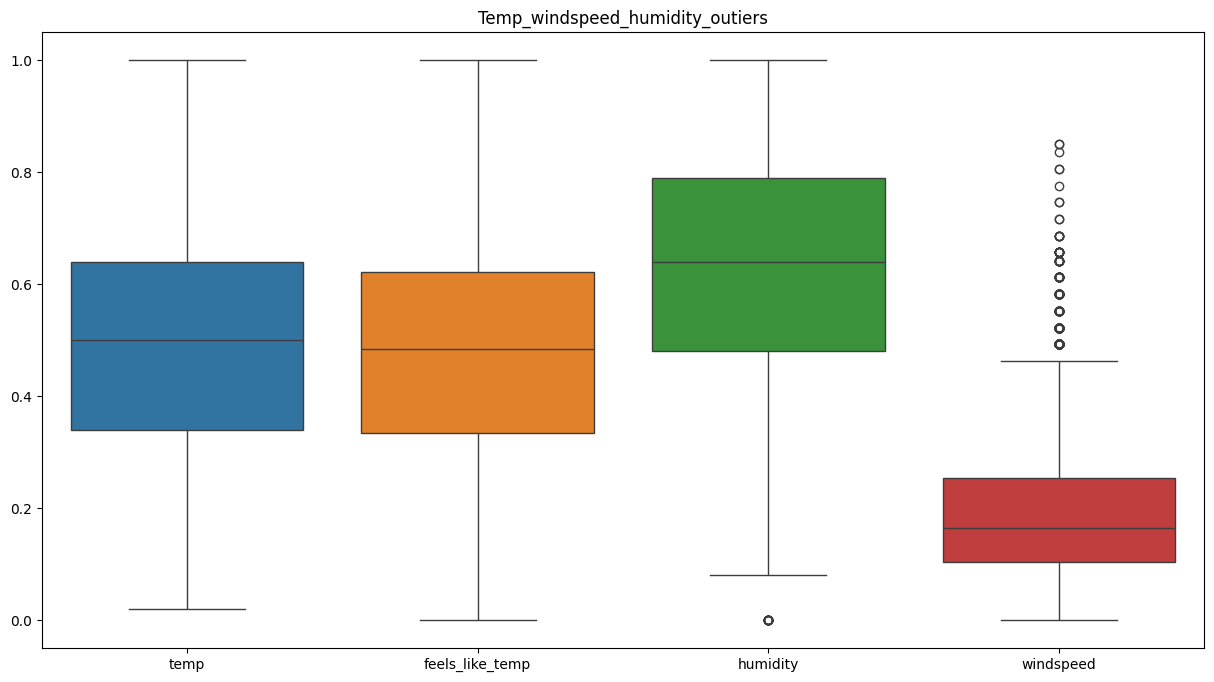

In [127]:
# List new numeric columns
new_num_cols = ['temp', 'feels_like_temp', 'humidity', 'windspeed']

fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=cleaned[new_num_cols])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

##### We see some outliers for windspeed but would not impute or remove them as tree based algorithms we would be using are robust to outliers

#### Let us check how windspeed affects the rent count

In [128]:
# Compare average rental counts between windspeed = 0 and > 0
zero_wind_avg = cleaned[cleaned['windspeed'] == 0]['total_bike_rented_count'].mean()
nonzero_wind_avg = cleaned[cleaned['windspeed'] > 0]['total_bike_rented_count'].mean()

print(f"Average rentals when windspeed = 0: {zero_wind_avg:.2f}")
print(f"Average rentals when windspeed > 0: {nonzero_wind_avg:.2f}")

Average rentals when windspeed = 0: 143.20
Average rentals when windspeed > 0: 171.02


##### It seems people prefer to ride more in a breezy weather. But wait, can we infer the same yet.

In [85]:
!pip install fancyimpute

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.4 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=d56e13af7dcd0faf15d44d7e7bfb93ce8de9b5a22ec9fe2b7cba594c396652a1
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=b273ae2eff8e931534d75bc8f124cca9925ae4a7ca259f544d6d74ec4618f731
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute


In [129]:
from fancyimpute import KNN
import numpy as np

# copy of the cleaned data
df = cleaned.copy()

# Identifying outliers using IQR (as intended)
q1 = df['windspeed'].quantile(0.25)
q3 = df['windspeed'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Marking only outliers (not all 0s) as NaN for imputation
outlier_mask = (df['windspeed'] < lower_bound) | (df['windspeed'] > upper_bound)
df.loc[outlier_mask, 'windspeed'] = np.nan

# Preparing features for KNN imputation
df['season_code']     = df['season'].astype('category').cat.codes
df['workingday_code'] = df['workingday'].astype('category').cat.codes
df['hr']              = df['hr'].astype(int)

impute_cols = [
    'temp', 'humidity', 'feels_like_temp',
    'windspeed', 'season_code', 'hr', 'workingday_code'
]

X = df[impute_cols].values

# Applying fancyimpute KNN
knn_imputer = KNN(k=5, verbose=True)
X_imputed = knn_imputer.fit_transform(X)

# Replacing only outlier positions with imputed values
df['windspeed'] = X_imputed[:, impute_cols.index('windspeed')]

# Dropping temp columns
df.drop(columns=['season_code', 'workingday_code'], inplace=True)

# Saving back to cleaned
cleaned = df

# Final check
print("✅ Windspeed 0s remaining:", (cleaned['windspeed'] == 0).sum())
print("✅ Windspeed NaNs remaining:", cleaned['windspeed'].isna().sum())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Imputing row 1/16678 with 0 missing, elapsed time: 36.656
Imputing row 101/16678 with 0 missing, elapsed time: 36.656
Imputing row 201/16678 with 0 missing, elapsed time: 36.657
Imputing row 301/16678 with 0 missing, elapsed time: 36.658
Imputing row 401/16678 with 0 missing, elapsed time: 36.658
Imputing row 501/16678 with 0 missing, elapsed time: 36.658
Imputing row 601/16678 with 0 missing, elapsed time: 36.659
Imputing row 701/16678 with 0 missing, elapsed time: 36.659
Imputing row 801/16678 with 0 missing, elapsed time: 36.659
Imputing row 901/16678 with 0 missing, elapsed time: 36.660
Imputing row 1001/16678 with 0 missing, elapsed time: 36.660
Imputing row 1101/16678 with 0 missing, elapsed time: 36.661
Imputing row 1201/16678 with 0 missing, elapsed time: 36.663
Imputing row 1301/16678 with 0 missing, elapsed time: 36.663
Imputing row 1401/16678 with 0 missing, elapsed time: 36.664
Imputing row 1501/16678 with 0 missing, elapsed time: 36.664
Imputing row 1601/16678 with 0 missi

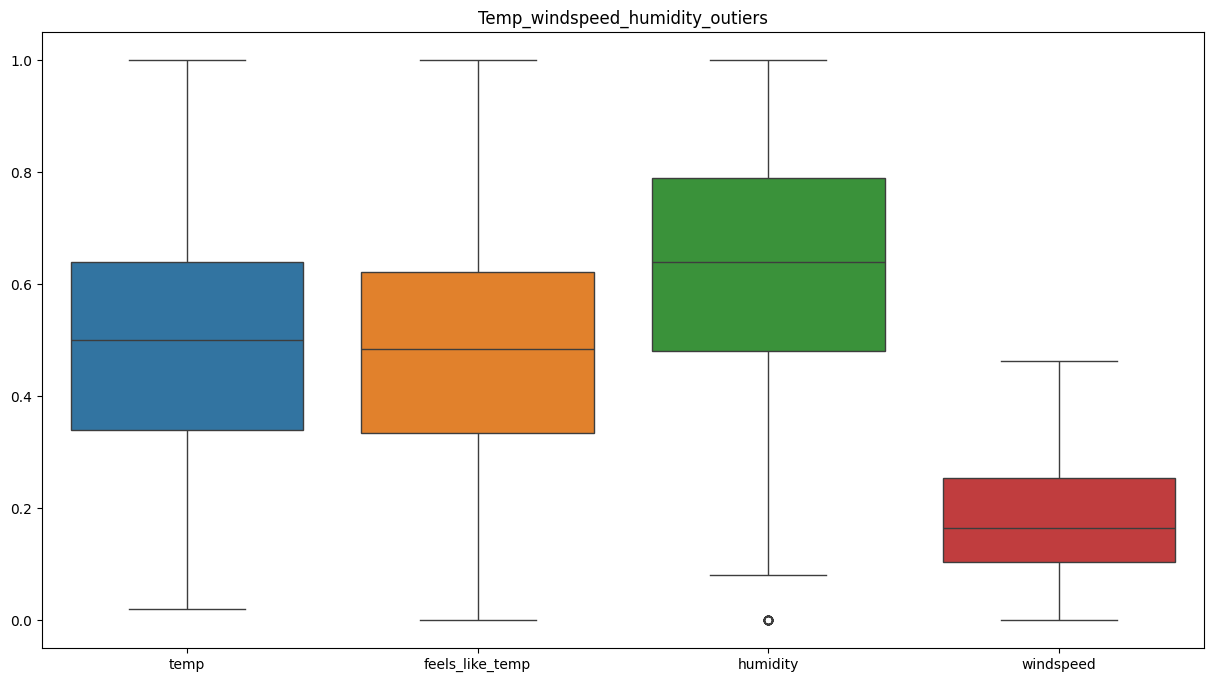

In [ ]:
# Verifying the imputation results
new_num_cols = ['temp', 'feels_like_temp', 'humidity', 'windspeed']

fig,ax=plt.subplots(figsize=(15,8))
#Box plot for Temp_windspeed_humidity_outliers
sns.boxplot(data=cleaned[new_num_cols])
ax.set_title('Temp_windspeed_humidity_outiers')
plt.show()

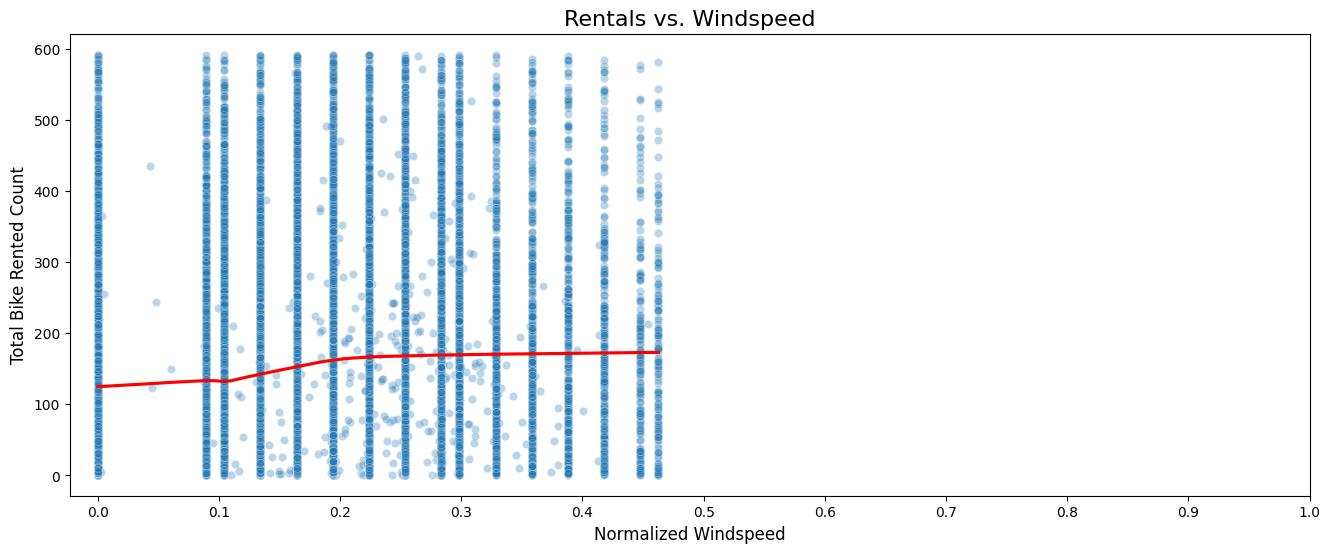

In [ ]:
# Visualizing the relationship between windspeed and total bike rentals
plt.figure(figsize=(16,6))
sns.scatterplot(
    data=cleaned,
    x='windspeed',
    y='total_bike_rented_count',
    alpha=0.3
)
# adding a lowess‐smoothed line
sns.regplot(
    data=cleaned,
    x='windspeed',
    y='total_bike_rented_count',
    scatter=False,
    lowess=True,
    color='red'
)
plt.title('Rentals vs. Windspeed', fontsize=16)
plt.xlabel('Normalized Windspeed', fontsize=12)
plt.ylabel('Total Bike Rented Count', fontsize=12)

# Set xticks every 0.1 from 0.0 to 1.0
plt.xticks(np.arange(0.0, 1.01, 0.1))

plt.show()

#### So we are seeing that:



*   At zero wind (the left‐most vertical “stripe”), average rentals are around 130–140.

*  As you move into light breezes (windspeed ~0.2–0.34), average rentals rise to about 180–200.

*   Past moderate wind (windspeed > 0.34), the average gradually falls back toward 150–160.









#### Also let us check the correlation among these continuous features and with the target feature

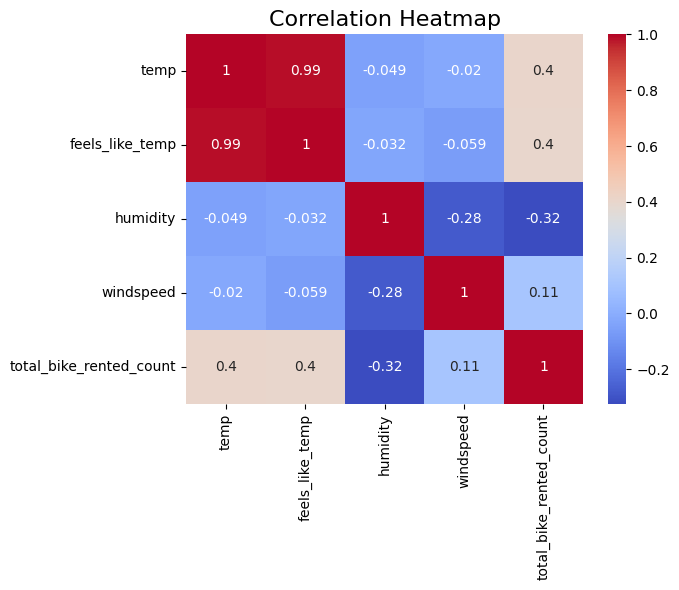

In [134]:
corr_cols= [
    'temp', 'feels_like_temp', 'humidity', 'windspeed', 'total_bike_rented_count'
]

corr_df = cleaned[corr_cols]
sns.heatmap(corr_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

### Now let us do a distribution plot of the target variable  with Seaborn Histplot

/tmp/ipython-input-135-4078200883.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12);
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


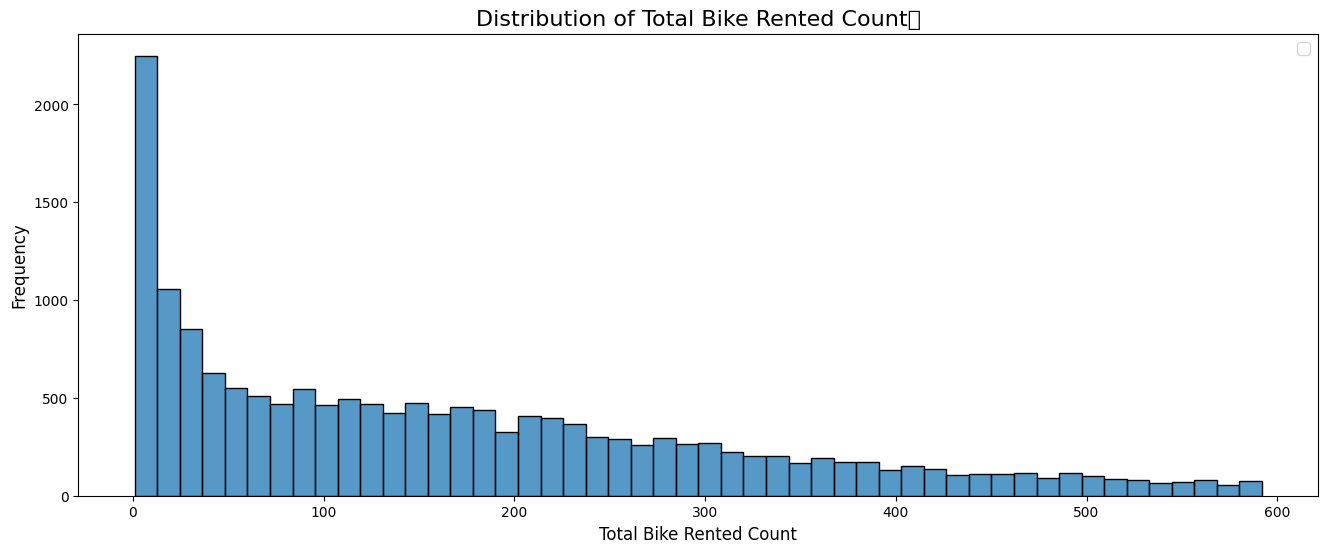

In [135]:
plt.figure(figsize=(16, 6))
sns.histplot(cleaned.total_bike_rented_count	, bins=50)
#sns.histplot(ori_df.total_bike_rented_count[ori_df.total_bike_rented_count<50], kde=True)
plt.title("Distribution of Total Bike Rented Count	", fontsize=16)
plt.xlabel("Total Bike Rented Count", fontsize=12)
#plt.xticks(np.arange(0, 1001, 100))
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12);

##### We can see the target feature has a Long Tail Distribution

###  So let us apply logarithmic distribution to the target feature

In [136]:
log_rent_count = np.log1p(ori_df.total_bike_rented_count)

##### And check the target feature distibution again

/tmp/ipython-input-137-2415074942.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12);


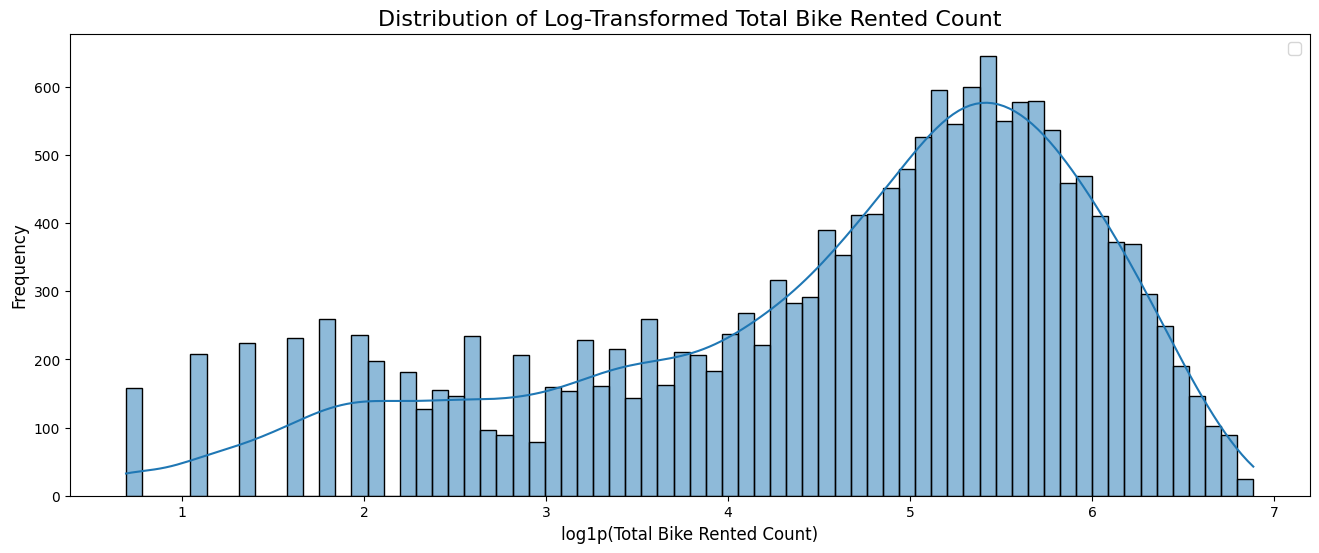

In [137]:
plt.figure(figsize=(16, 6))
# Plot histogram with KDE
sns.histplot(log_rent_count	, bins=70, kde=True)
plt.title("Distribution of Log-Transformed Total Bike Rented Count", fontsize=16)
plt.xlabel("log1p(Total Bike Rented Count)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(fontsize=12);

#### Now it seems far closer to a Normal Distribution than before

#### Final feature selection



*   Since the target variable is the sum of 'casual_users', 'registered_users', they would contribute to data leakage. So we shall drop them
*   Since "temp" and "feels_like_temp" are found to be highly co-related with each other, we would only keep "feels_like_temp" and also avoid multicollinearity .



In [138]:
del cleaned['temp']
del cleaned['registered_users']
del cleaned['casual_users']

In [139]:
# sanity-check
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16678 entries, 2011-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   season                   16678 non-null  int64  
 1   year                     16678 non-null  int64  
 2   month                    16678 non-null  int64  
 3   hr                       16678 non-null  int64  
 4   holiday                  16678 non-null  int64  
 5   weekday                  16678 non-null  int64  
 6   workingday               16678 non-null  int64  
 7   weather_condition        16678 non-null  int64  
 8   feels_like_temp          16678 non-null  float64
 9   humidity                 16678 non-null  float64
 10  windspeed                16678 non-null  float64
 11  total_bike_rented_count  16678 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.7 MB


### We now need to split and save the data for train, validattion and test in a chronological order. We shall use the test dataset later as reference to the Evidently monitoring. Here we shall :



*   We have 24 months of data in this dataset
*   We shall form the train set from the first 12 months (2011)
*   We shall validate the model with the next 4 months (13-16) data
*   Finally we shall for the unseen test set with the next 4 months (17-20) data
*   This test set data shall also be used as reference data in MLOPS monitoring
*   The last months data (21-24) shall be part of the current data set (in month-wise batch or as a whole) to check drift







In [140]:
# let us make a copy of the cleaned dataframe for this purpose
new_df = cleaned.copy()
# Adding the log‑target
new_df['log_total_count'] = np.log1p(new_df['total_bike_rented_count'])
# Ensuring it’s sorted by datetime index although no operations have yet been perrformed to disrupt the order
new_df = new_df.sort_index()

In [144]:
# chronological splits by absolute date
full_train_df = new_df[:'2012-04-30']
train_df = new_df[:'2011-12-31']                  # months  1–12 (2011)
val_df   = new_df['2012-01-01':'2012-04-30']      # months 13–16 (Jan–Apr 2012)
test_df  = new_df['2012-05-01':'2012-08-31']      # months 17–20 (May–Aug 2012)
drift_test_df = new_df['2012-09-01':'2012-12-31']      # months 21–24 (Sep–Dec 2012)

In [147]:
# Sanity‑check
print("Full train:", full_train_df.shape)
print("Train:",   train_df.shape)
print("Validation:",   val_df.shape)
print("Test:",    test_df.shape)
print("Drift Monitoring Set:",   drift_test_df.shape)

Full train: (11391, 13)
Train: (8619, 13)
Validation: (2772, 13)
Test: (2650, 13)
Drift Monitoring Set: (2637, 13)


In [ ]:
# Save each for modeling & monitoring
#rain_df.to_csv('./data/train.csv', index=True)
#val_df.to_csv('./data/validation.csv', index=True)
test_df.to_csv('./data/reference_data.csv', index=True)
drift_test_df.to_csv('./data/current_data.csv', index=True)

## Now let us proceed to train the model

### Preparing the splits

In [177]:
#train_df = pd.read_csv('./data/train.csv')
#val_df = pd.read_csv('./data/validation.csv')

In [152]:
X_full_train = full_train_df.drop(columns='total_bike_rented_count').reset_index(drop=True)
y_full_train = X_full_train.log_total_count.values
del X_full_train['log_total_count']

In [158]:
X_train = train_df.drop(columns='total_bike_rented_count').reset_index(drop=True)
y_train = X_train.log_total_count.values
del X_train['log_total_count']

In [159]:
X_val = val_df.drop(columns='total_bike_rented_count').reset_index(drop=True)
y_val = X_val.log_total_count.values
del X_val['log_total_count']

In [160]:
# Sanity‑check
X_full_train.shape, y_full_train.shape, X_train.shape, y_train.shape, X_val.shape, y_val.shape

((11391, 11), (11391,), (8619, 11), (8619,), (2772, 11), (2772,))

________________________________________________________________________________________________________________________________________________________________

#### Since all our features are already numeric (either ordinal or continuous), we don’t actually need the DictVectorizer step at all.

________________________________________________________________________________________________________________________________________________________________

#### Linear Regression

In [161]:
# Initialize and fit the model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [162]:
# Predict
y_pred = lr.predict(X_val)

In [163]:
# Evaluating with RMSE
rmse = root_mean_squared_error(y_val, y_pred)
print(f'Validation RMSE: {rmse:.2f}')

Validation RMSE: 1.23


In [164]:
# Back-transform to original scale and evaluate RMSE
y_val_actual = np.expm1(y_val)
y_pred_actual = np.expm1(y_pred)

rmse_actual = root_mean_squared_error(y_val_actual, y_pred_actual)
print(f'Validation RMSE (actual scale): {rmse_actual:.2f}')

Validation RMSE (actual scale): 155.92


In [165]:
def evaluateMetrics(y_true, y_pred):
  # Mean Squared Error
  mse_lr = mean_squared_error(y_true, y_pred)

  # Root Mean Squared Error
  rmse_lr = np.sqrt(mse_lr)

  # Mean Absolute Error
  mae_lr = mean_absolute_error(y_true, y_pred)

  # R-squared
  r2_lr = r2_score(y_true, y_pred)

  # Print Metrics
  print(f'MSE: {mse_lr:.4f}')
  print(f'RMSE: {rmse_lr:.4f}')
  print(f'MAE: {mae_lr:.4f}')
  print(f'R²: {r2_lr:.4f}')

In [166]:
# evaluating and printing metrics for the Linear Regression model
evaluateMetrics(y_val, y_pred)

MSE: 1.5017
RMSE: 1.2255
MAE: 1.0214
R²: 0.2659


In [167]:
# evaluating and printing metrics for the Linear Regression model on actual bike rental count
evaluateMetrics(y_val_actual, y_pred_actual)

MSE: 24309.5374
RMSE: 155.9152
MAE: 107.9490
R²: -0.1517


In [256]:
lr = LinearRegression()

# Get OOF predictions in log space
y_pred_log = cross_val_predict(
    lr,
    X_full_train,
    y_full_train,   # this is log1p(count)
    cv=5,
    n_jobs=-1
)

# Back-transform both preds and truths to original counts
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_full_train)

# 3) Compute metrics on original scale
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# print(f"CV RMSE (actual counts): {rmse:.2f}")
# print(f"CV R² (actual counts):   {r2:.4f}")
evaluateMetrics(y_true,y_pred)

MSE: 16249.2245
RMSE: 127.4724
MAE: 86.6477
R²: 0.1129


In [253]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [257]:
rmsle(y_true,y_pred, False)

np.float64(1.0349322705689217)

In [258]:
mean_squared_log_error(y_true,y_pred)

1.0710848046649435

### RandomForrestRegressor

In [178]:
# Actual target from CSV
y_val_actual = np.expm1(y_val)

In [183]:
# Find the Best n_estimators

# Store results
n_estimators_list = list(range(5, 101, 5))
r2_scores = []
rmse_scores = []

for n in n_estimators_list:
    rf_model = RandomForestRegressor(n_estimators=n, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict using the validation dataset
    y_pred_rf = rf_model.predict(X_val)
    y_pred_rf_actual = np.expm1(y_pred_rf)

    # Compute R² score
    r2 = r2_score(y_val_actual, y_pred_rf_actual)
    r2_scores.append(r2)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_rf_actual))
    rmse_scores.append(rmse)

    print(f'n_estimators = {n} -------> R² = {r2:.4f}, RMSE = {rmse:.4f}')
    print()

n_estimators = 5 -------> R² = 0.3588, RMSE = 116.3343

n_estimators = 10 -------> R² = 0.3742, RMSE = 114.9297

n_estimators = 15 -------> R² = 0.3757, RMSE = 114.7965

n_estimators = 20 -------> R² = 0.3650, RMSE = 115.7700

n_estimators = 25 -------> R² = 0.3666, RMSE = 115.6284

n_estimators = 30 -------> R² = 0.3675, RMSE = 115.5495

n_estimators = 35 -------> R² = 0.3700, RMSE = 115.3169

n_estimators = 40 -------> R² = 0.3713, RMSE = 115.1936

n_estimators = 45 -------> R² = 0.3687, RMSE = 115.4323

n_estimators = 50 -------> R² = 0.3703, RMSE = 115.2931

n_estimators = 55 -------> R² = 0.3704, RMSE = 115.2776

n_estimators = 60 -------> R² = 0.3693, RMSE = 115.3803

n_estimators = 65 -------> R² = 0.3686, RMSE = 115.4433

n_estimators = 70 -------> R² = 0.3692, RMSE = 115.3892

n_estimators = 75 -------> R² = 0.3693, RMSE = 115.3819

n_estimators = 80 -------> R² = 0.3722, RMSE = 115.1190

n_estimators = 85 -------> R² = 0.3700, RMSE = 115.3184

n_estimators = 90 -------> R² = 

In [186]:
# We take best evaluated n_estimators = 15 and evaluate the best max_depth value
# Find the Best max_depth
# Store results
n_estimators = 15
r2_scores = []
rmse_scores = []
depth_list = [5, 7, 9, 10, 11, 13, 15, 20, 25, 30, 35, 40, 45, 50]
for depth in depth_list:
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_depth = depth, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict using the validation dataset
    y_pred_rf = rf_model.predict(X_val)
    y_pred_rf_actual = np.expm1(y_pred_rf)


    # Compute R² score
    r2 = r2_score(y_val_actual, y_pred_rf_actual)
    r2_scores.append(r2)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_rf_actual))
    rmse_scores.append(rmse)

    print(f'depth = {depth} -------> R² = {r2:.4f}, RMSE = {rmse:.4f}')
    print()

depth = 5 -------> R² = 0.2276, RMSE = 127.6858

depth = 7 -------> R² = 0.2983, RMSE = 121.7062

depth = 9 -------> R² = 0.3347, RMSE = 118.5012

depth = 10 -------> R² = 0.3428, RMSE = 117.7770

depth = 11 -------> R² = 0.3408, RMSE = 117.9622

depth = 13 -------> R² = 0.3604, RMSE = 116.1952

depth = 15 -------> R² = 0.3702, RMSE = 115.3017

depth = 20 -------> R² = 0.3751, RMSE = 114.8448

depth = 25 -------> R² = 0.3750, RMSE = 114.8567

depth = 30 -------> R² = 0.3756, RMSE = 114.8076

depth = 35 -------> R² = 0.3757, RMSE = 114.7965

depth = 40 -------> R² = 0.3757, RMSE = 114.7965

depth = 45 -------> R² = 0.3757, RMSE = 114.7965

depth = 50 -------> R² = 0.3757, RMSE = 114.7965



In [188]:
# We take the best evaluated max_depth = 30 and find the best min_samples_leaf value
# Find the Best min_samples_leaf
# Store results
n_estimators = 15
max_depth = 35
r2_scores = []
rmse_scores = []
leaf_samples_list =  [1, 3, 5, 6, 10, 15, 20, 50, 100, 200, 500]
for leaf_samples in leaf_samples_list:
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42, max_depth = max_depth, min_samples_leaf = leaf_samples, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Predict using the validation dataset
    y_pred_rf = rf_model.predict(X_val)
    y_pred_rf_actual = np.expm1(y_pred_rf)

    # Compute R² score
    r2 = r2_score(y_val_actual, y_pred_rf_actual)
    r2_scores.append(r2)

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(y_val_actual, y_pred_rf_actual))
    rmse_scores.append(rmse)

    print(f'leaf_samples = {leaf_samples} -------> R² = {r2:.4f}, RMSE = {rmse:.4f}')
    print()

leaf_samples = 1 -------> R² = 0.3757, RMSE = 114.7965

leaf_samples = 3 -------> R² = 0.3769, RMSE = 114.6824

leaf_samples = 5 -------> R² = 0.3733, RMSE = 115.0186

leaf_samples = 6 -------> R² = 0.3683, RMSE = 115.4733

leaf_samples = 10 -------> R² = 0.3589, RMSE = 116.3299

leaf_samples = 15 -------> R² = 0.3495, RMSE = 117.1758

leaf_samples = 20 -------> R² = 0.3437, RMSE = 117.6984

leaf_samples = 50 -------> R² = 0.3006, RMSE = 121.5020

leaf_samples = 100 -------> R² = 0.2834, RMSE = 122.9838

leaf_samples = 200 -------> R² = 0.2185, RMSE = 128.4334

leaf_samples = 500 -------> R² = 0.1284, RMSE = 135.6361



We can see the best point is min_samples_leaf = 3 where R² is highest and RMSE is lowest. So best parameter value of the Random Forrest n_estimators = 15, max_depth = 35 and min_samples_leaf = 3

In [214]:
# Train the hypertuned model
rf = RandomForestRegressor(
    n_estimators = 15,
    max_depth = 35,
    min_samples_leaf = 3,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)  # Use the actual rental counts (not log-transformed)

# Predict
y_pred_val_rf = rf.predict(X_val)
y_pred_rf_actual = np.expm1(y_pred_val_rf)

In [215]:
# evaluating and printing metrics for the Random Forrest model
evaluateMetrics(y_val_actual, y_pred_rf_actual)

MSE: 13152.0596
RMSE: 114.6824
MAE: 81.7234
R²: 0.3769


In [216]:
#accuracy of the model
rf_score =rf.score(X_train, y_train)
print('Accuracy of the model :', rf_score)

Accuracy of the model : 0.974624330415576


In [271]:
rf_full = RandomForestRegressor(
    n_estimators=15,
    max_depth=35,
    min_samples_leaf=3,
    random_state=42,
    n_jobs=-1
)

# 1) Get OOF predictions in log space
y_pred_log = cross_val_predict(
    rf_full,
    X_full_train,
    y_full_train,   # this is log1p(count)
    cv=5,
    n_jobs=-1
)

# 2) Back-transform both preds and truths to original counts
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_full_train)

# 3) Compute metrics on original scale
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2   = r2_score(y_true, y_pred)

# print(f"CV RMSE (actual counts): {rmse:.2f}")
# print(f"CV R² (actual counts):   {r2:.4f}")
evaluateMetrics(y_true,y_pred)

MSE: 4802.8879
RMSE: 69.3029
MAE: 44.7077
R²: 0.7378


In [272]:
rmsle(y_true, y_pred, False)

np.float64(0.5018969687945549)

In [273]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(y_true, y_pred)

0.2519005672851624

### XGBoost

In [223]:
!pip install xgboost

In [224]:
# import the libraries
import xgboost as xgb
from xgboost import DMatrix, train

In [225]:
# fundtion to find best value of input xgb_params parameter for the model
def train_tune_xgboost(dtrain, dval,  param_name, param_values, base_params):
  scores_param = {}
  #for value in param_values:
  for value in param_values:
    xgb_params = base_params.copy()  # Copy base params to avoid overwriting
    xgb_params[param_name] = value
    print(xgb_params)
    # To capture evaluation results
    evals_result = {}
    #output_key = f"eta={xgb_params['eta']}"
    output_key = f"{param_name}={xgb_params[param_name]}"
    # Training the model with tracking
    model = train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=200, # boost rounds is taken to be 200 as we had seen best n_estimators = 200 earlier for the tuned RandomForestClassifier model
        evals=[(dtrain, 'train'), (dval, 'val')],
        evals_result=evals_result,  # This captures the train and val results
        verbose_eval=10
    )

    # Store scores with the eta key
    scores_param[output_key] = evals_result['val']['rmse']  # Store validation AUC scores for the key
    # Example outputs
    print(output_key)  # Outputs: current param name

  # The print statement should be at the same indentation level as the for loop
  print(scores_param.keys())  # Outputs: dictionary of param names with param values
  return scores_param

In [226]:
# setting the dtrain and dval
dtrain = DMatrix(data=X_train, label=y_train)
dval = DMatrix(data=X_val, label=y_val)

In [231]:
# this is a xgb_params with all default values except the calculated scale_pos_weight
xgb_params = {
      'eta': 0.3,
      'max_depth': 6,
      'min_child_weight': 1,
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse',
      'nthread': 8,
      'seed': 42,
      'verbosity': 1
  }

In [232]:
# evaluating the best eta
param_name = 'eta'
param_values = [0.001, 0.01, 0.05, 0.1, 0.3, 1]
scores_param_eta = train_tune_xgboost(dtrain, dval,  param_name, param_values, xgb_params)

{'eta': 0.001, 'max_depth': 6, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'nthread': 8, 'seed': 42, 'verbosity': 1}
[0]	train-rmse:1.36835	val-rmse:1.43503
[10]	train-rmse:1.35678	val-rmse:1.42348
[20]	train-rmse:1.34535	val-rmse:1.41209
[30]	train-rmse:1.33404	val-rmse:1.40084
[40]	train-rmse:1.32286	val-rmse:1.38974
[50]	train-rmse:1.31180	val-rmse:1.37876
[60]	train-rmse:1.30083	val-rmse:1.36783
[70]	train-rmse:1.28996	val-rmse:1.35700
[80]	train-rmse:1.27922	val-rmse:1.34635
[90]	train-rmse:1.26859	val-rmse:1.33579
[100]	train-rmse:1.25810	val-rmse:1.32541
[110]	train-rmse:1.24771	val-rmse:1.31522
[120]	train-rmse:1.23745	val-rmse:1.30517
[130]	train-rmse:1.22728	val-rmse:1.29522
[140]	train-rmse:1.21722	val-rmse:1.28541
[150]	train-rmse:1.20728	val-rmse:1.27575
[160]	train-rmse:1.19744	val-rmse:1.26618
[170]	train-rmse:1.18770	val-rmse:1.25672
[180]	train-rmse:1.17803	val-rmse:1.24731
[190]	train-rmse:1.16846	val-rmse:1.23803
[199]	train-rmse:1.

best eta = 0.05

In [233]:
xgb_params = {
      'eta': 0.05, # from above step
      'max_depth': 6,
      'min_child_weight': 1,
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse',
      'nthread': 8,
      'seed': 42,
      'verbosity': 1
  }

In [234]:
# evaluating the best max_depth
param_name = 'max_depth'
param_values = [3, 6, 8, 10, 15, 20, 25, 30, 35, 40]
scores_param_max_depth = train_tune_xgboost(dtrain, dval,  param_name, param_values, xgb_params)

{'eta': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'nthread': 8, 'seed': 42, 'verbosity': 1}
[0]	train-rmse:1.32037	val-rmse:1.39418
[10]	train-rmse:0.97581	val-rmse:1.07382
[20]	train-rmse:0.78624	val-rmse:0.91594
[30]	train-rmse:0.68097	val-rmse:0.84303
[40]	train-rmse:0.61753	val-rmse:0.80738
[50]	train-rmse:0.58042	val-rmse:0.79109
[60]	train-rmse:0.55833	val-rmse:0.79923
[70]	train-rmse:0.54254	val-rmse:0.80648
[80]	train-rmse:0.53058	val-rmse:0.81094
[90]	train-rmse:0.51970	val-rmse:0.80912
[100]	train-rmse:0.50381	val-rmse:0.80425
[110]	train-rmse:0.49522	val-rmse:0.80258
[120]	train-rmse:0.48759	val-rmse:0.80186
[130]	train-rmse:0.48030	val-rmse:0.79961
[140]	train-rmse:0.47418	val-rmse:0.79672
[150]	train-rmse:0.46983	val-rmse:0.79655
[160]	train-rmse:0.45478	val-rmse:0.78870
[170]	train-rmse:0.42778	val-rmse:0.77272
[180]	train-rmse:0.41107	val-rmse:0.76358
[190]	train-rmse:0.40812	val-rmse:0.76333
[199]	train-rmse:0.4

max_depth = 8

In [236]:
xgb_params = {
      'eta': 0.05,
      'max_depth': 8, # from above step
      'min_child_weight': 1,
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse',
      'nthread': 8,
      'seed': 42,
      'verbosity': 1
  }

In [237]:
# # evaluating the best min_child_weight
param_name = 'min_child_weight'
param_values = [1, 3, 5, 7, 10, 13, 15, 20, 25, 30]
scores_param_min_child_weight = train_tune_xgboost(dtrain, dval,  param_name, param_values, xgb_params)

{'eta': 0.05, 'max_depth': 8, 'min_child_weight': 1, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'nthread': 8, 'seed': 42, 'verbosity': 1}
[0]	train-rmse:1.30759	val-rmse:1.37787
[10]	train-rmse:0.84422	val-rmse:0.98061
[20]	train-rmse:0.57655	val-rmse:0.80541
[30]	train-rmse:0.42597	val-rmse:0.74303
[40]	train-rmse:0.34295	val-rmse:0.72725
[50]	train-rmse:0.29269	val-rmse:0.72511
[60]	train-rmse:0.26068	val-rmse:0.73059
[70]	train-rmse:0.24103	val-rmse:0.73501
[80]	train-rmse:0.22749	val-rmse:0.73867
[90]	train-rmse:0.21599	val-rmse:0.73999
[100]	train-rmse:0.20704	val-rmse:0.74080
[110]	train-rmse:0.20110	val-rmse:0.74131
[120]	train-rmse:0.19367	val-rmse:0.74139
[130]	train-rmse:0.18881	val-rmse:0.74345
[140]	train-rmse:0.18466	val-rmse:0.74498
[150]	train-rmse:0.18168	val-rmse:0.74600
[160]	train-rmse:0.17875	val-rmse:0.74638
[170]	train-rmse:0.17543	val-rmse:0.74682
[180]	train-rmse:0.17255	val-rmse:0.74702
[190]	train-rmse:0.16955	val-rmse:0.74704
[199]	train-rmse:0.1

min_child_weight = 3

In [238]:
xgb_params = {
      'eta': 0.05,
      'max_depth': 8,
      'min_child_weight': 3,  # from above step
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse',
      'nthread': 8,
      'seed': 42,
      'verbosity': 1
  }

In [240]:
# training the model with tuned paramenters and updated boosting rounds
model_tuned = train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=50, # boost rounds as evaluated from above
        evals=[(dtrain, 'train_tune'), (dval, 'val_tuned')],  # This captures the train and val results
        verbose_eval=10
    )

[0]	train_tune-rmse:1.30762	val_tuned-rmse:1.37778
[10]	train_tune-rmse:0.84455	val_tuned-rmse:0.98045
[20]	train_tune-rmse:0.57676	val_tuned-rmse:0.80337
[30]	train_tune-rmse:0.42654	val_tuned-rmse:0.74262
[40]	train_tune-rmse:0.34387	val_tuned-rmse:0.72578
[49]	train_tune-rmse:0.29860	val_tuned-rmse:0.72460


In [263]:
#  Prepare the DMatrix for your validation or test set
dval = xgb.DMatrix(X_val)

#  Predict in log‑space, then back‑transform
y_pred_log = model_tuned.predict(dval)
y_pred_no_log = np.expm1(y_pred_log)  # inverse of log1p
#  Get the true counts from your DataFrame
y_true = val_df['total_bike_rented_count'].values

In [264]:
evaluateMetrics(y_val_actual, y_pred_no_log)

MSE: 15532.2355
RMSE: 124.6284
MAE: 86.5301
R²: 0.2641


In [265]:
rmsle(y_val_actual, y_pred_no_log, False)

np.float64(0.7246025980030677)

In [266]:
mean_squared_log_error(y_val_actual, y_pred_no_log)

0.5250489248220052

## So we can conclude the best model is still the Randon Forest Regressor model

In [269]:
# we prepare the test split
X_test = test_df.drop(columns='total_bike_rented_count').reset_index(drop=True)
y_test = X_test.log_total_count.values
del X_test['log_total_count']

In [270]:
# sanity-check
X_test.shape, y_test.shape

((2650, 11), (2650,))

In [276]:
# Fit the model to the full training data
rf_full.fit(X_full_train, y_full_train)

# Predict log-space, back-transform
y_test_pred_log = rf_full.predict(X_test)
y_test_pred_actual = np.expm1(y_test_pred_log)

In [277]:
# Evaluate on actual scale
y_test_actual = test_df['total_bike_rented_count'].values

In [279]:
y_test_actual

array([ 35,  21,   8, ..., 303, 277, 174])

In [281]:
y_test_pred_actual

array([ 27.64130516,  14.2168645 ,   7.84250593, ..., 268.87122526,
       202.49353569, 151.85509462])

In [280]:
print("Random Forest Regressor Performance on Test Set:")
evaluateMetrics(y_test_actual, y_test_pred_actual)

Random Forest Regressor Performance on Test Set:
MSE: 4083.9732
RMSE: 63.9060
MAE: 42.1293
R²: 0.8541


In [286]:
rmsle(y_test_actual, y_test_pred_actual, False)

np.float64(0.35561194306702737)

In [287]:
mean_squared_log_error(y_test_actual, y_test_pred_actual)

0.12645985405190668

### Visualize predictions vs actuals

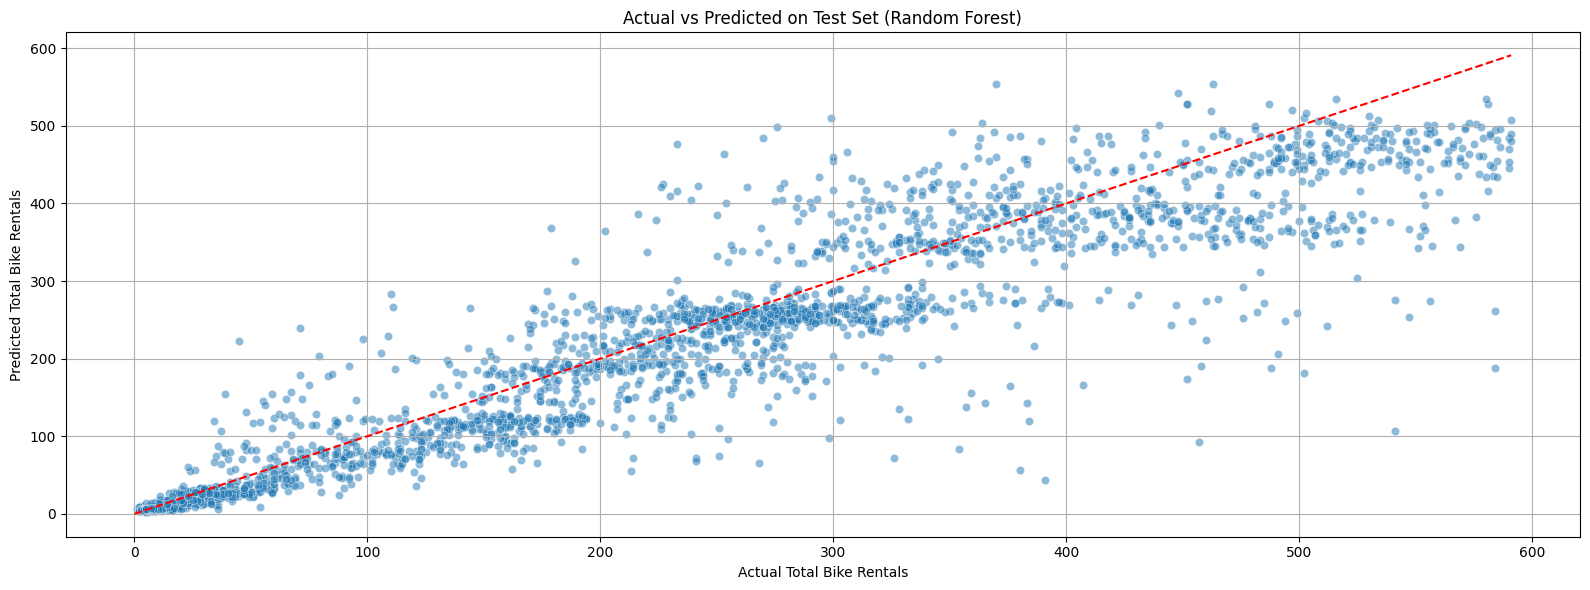

In [284]:
plt.figure(figsize=(16, 6))
sns.scatterplot(x=y_test_actual, y=y_test_pred_actual, alpha=0.5)
plt.xlabel("Actual Total Bike Rentals")
plt.ylabel("Predicted Total Bike Rentals")
plt.title("Actual vs Predicted on Test Set (Random Forest)")
plt.plot([0, max(y_test_actual)], [0, max(y_test_actual)], color='red', linestyle='--')  # diagonal line
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation:

*   The red dashed line represents the ideal y = x line, where predicted equals actual

*   Most points are clustered near the diagonal, especially for counts up to ~300

*  At higher values (400–600), there's some underestimation — the model predicts slightly lower than actual. This is common in Random Forests, which tend to regress toward the mean (they struggle with outliers/extreme values).





### Residual Plot

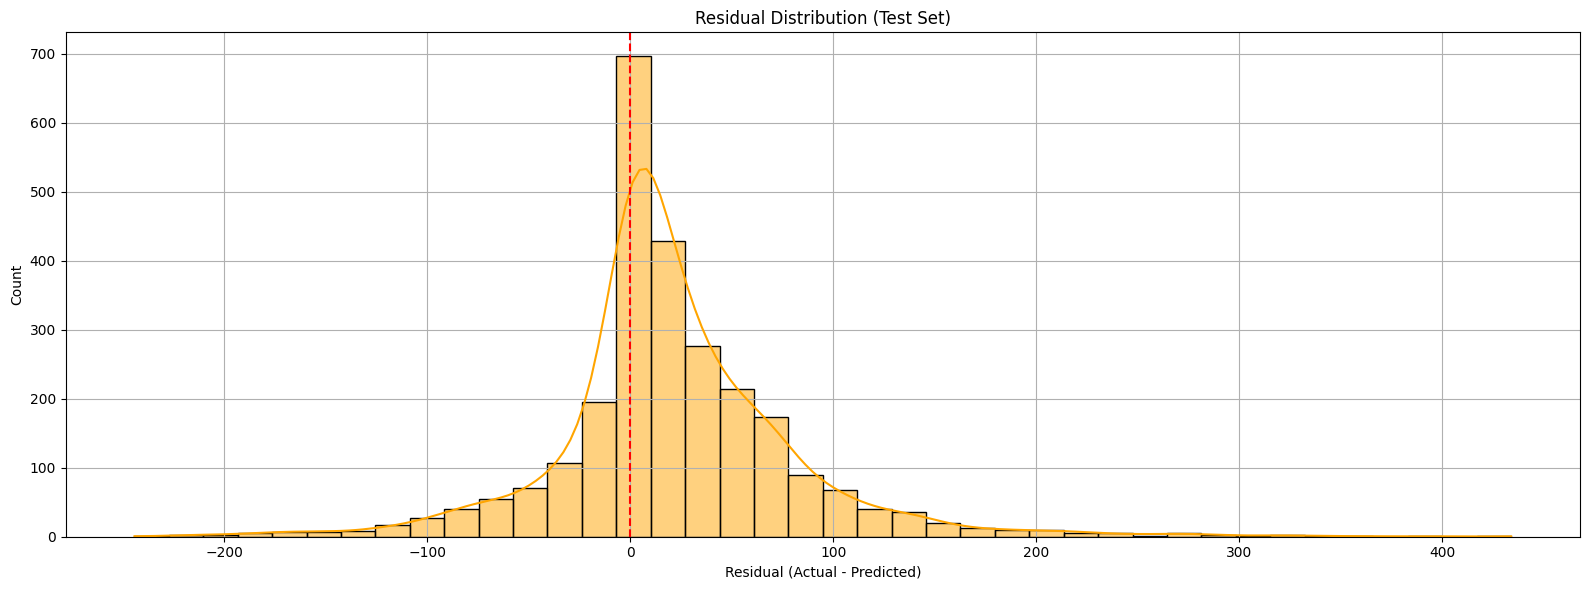

In [285]:
residuals = y_test_actual - y_test_pred_actual

plt.figure(figsize=(16, 6))
sns.histplot(residuals, bins=40, kde=True, color='orange')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residual Distribution (Test Set)")
plt.grid(True)
plt.tight_layout()
plt.show()

### We observe that



*   Plot is Symmetric around zero: The residuals are fairly centered at 0, indicated by the red dashed line.

*   Slight positive skew: There's a longer right tail, meaning the model occasionally underpredicts by a large amount (actual - predicted is large and positive)

*   Presently, there is little time to make the model more accurate & robust because of the 29th July priject submission deadline; but I shall eventually make this model more efficient in comning times.

*   High peak near 0: Most residuals are small, and your mode is close to 0, meaning for most predictions, the error is minimal


### Saving the model

In [291]:
rf_full

RandomForestRegressor(max_depth=35, min_samples_leaf=3, n_estimators=15,
                      n_jobs=-1, random_state=42)

In [294]:
joblib.dump(rf_full, './models/rf_version-baseline.joblib')

['./models/rf_version-baseline.joblib']